# Исследование объявлений о продаже квартир

Исследуются данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно определить рыночную стоимость объектов недвижимости. Для этого проводится исследовательский анализ данных и устанавливаются параметры, влияющие на цену объектов. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Общая информация

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('D:\ds\ds.csv', sep='\t')
pd.set_option('display.max_columns', None)
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Смотрю на колонки, заполненные на основе данных геосервисов. Часть пропусков в колонках parks_nearest и ponds_nearest соответствуют значению 0 в колонках parks_around3000 и ponds_around3000. Логично предположить, что в данном случае пропуски означают отсутствие парков и водоёмов рядом с объектом. Но в то же время в таблице есть строки, где пропущены значения сразу по всем колонкам, заполненным автоматически. В этом случае пропуски скорее всего означают повреждение данных при выгрузке и выяснить фактическое значение не получится. Вернусь к ним позже.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

### Предобработка данных

Для начала устраню пропуски и приведу в порядок тип данных, где это можно сделать без дополнительной обработки. <br> 
Предположительно, пропуск в колонке balcony означает отстутствие балкона. Заполню пропуски значением 0. Тип данных изменю на целочисленный. <br>
Пропуски в колонке is_apartment скорее всего означают, что объект не является апартаментами. Заменю пропуски на булево False. <br>
Заменю пропуски в locality_name на unknown, чтоб привести данные в колонке к единому типу.<br>

In [5]:
df['floors_total'].describe()

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Медианой будет 9 этаж, но заполнять пропуски средним показателем этажности по всему городу и пригородам, вместе взятым, не самая лучшая идея. Нужно иметь представления хотя бы о том какой это тип застройки и где. Осмотрю выборку с пропусками.

In [6]:
print(df[df['floors_total'].isnull()]['floor'].unique())
df[df['floors_total'].isnull()]['locality_name'].value_counts()

[ 4  1 12  8  9 22 15  6  7  3 18 13 24 21 11  2  5 19 20 14 17 23 10]


Санкт-Петербург                    70
Красное Село                        2
поселок Мурино                      2
Кудрово                             2
посёлок Мурино                      2
посёлок Шушары                      1
посёлок Щеглово                     1
деревня Новое Девяткино             1
посёлок Бугры                       1
поселок городского типа Токсово     1
посёлок Стрельна                    1
городской посёлок Новоселье         1
Name: locality_name, dtype: int64

Большая часть пропусков в самом городе, но этажи представлены самые разные. Понятнее не стало. Поскольку пропусков небольшое количество, принимаю решение всё же заменить на медиану там, где общая этажность дома не будет превышена. Заодно приведу тип данных к целочисленному.

In [7]:
df.loc[df['floor'] <= 9, 'floors_total'] = df.loc[df['floor'] <= 9, 'floors_total'].fillna(9).astype('int64')

Перехожу к ceiling_height. Количество пропусков 9195 и это более трети всех строк.

In [8]:
df['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Среди значений есть полок высотой 100 метров и 1 метр. Что-то здесь не так. Хотя медиана и среднее выглядят похожими на правду - около 2,7 м. Займусь поиском аномалий. Яндекс подсказывает, что минимальная высота потолка в жилой квартире не должна быть ниже 2,4 м и обычно не бывает выше 4 м. Но поставим верхнюю границу в 6 метров, квартира может быть и двухуровневой.

In [9]:
ceiling_height_anomaly = df[(df['ceiling_height'] < 2.4) | (df['ceiling_height'] > 6)] #выбираю аномальные строки
ceiling_height_anomaly['ceiling_height'].value_counts() #смотрю на распределение аномальных значений

2.00      11
27.00      8
25.00      7
2.30       4
8.00       3
32.00      2
14.00      1
2.34       1
1.20       1
8.30       1
100.00     1
2.25       1
10.30      1
20.00      1
22.60      1
1.75       1
2.20       1
26.00      1
27.50      1
24.00      1
1.00       1
Name: ceiling_height, dtype: int64

Скорее всего все аномальные значения образовались в результате того, что продавец некорректно внёс данные. Можно было бы всё разом заменить на медиану 2,7м, но в случае с высотой потолков +- 20см могут влиять на конечную стоимость квартиры. Придётся повозиться. Посмотрю на таблицу.

In [10]:
ceiling_height_anomaly

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
227,13,2200000.0,47.00,2018-01-12T00:00:00,3,2.34,5.0,NaN,1,NaN,False,False,NaN,NaN,посёлок Новый Свет,NaN,NaN,NaN,NaN,NaN,NaN,45.0
355,17,3600000.0,55.20,2018-07-12T00:00:00,2,25.00,5.0,32.000000,2,False,False,False,NaN,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
552,11,2999000.0,33.50,2017-03-30T00:00:00,1,2.00,15.0,17.500000,6,NaN,False,False,6.50,NaN,Санкт-Петербург,33972.0,11746.0,1.0,520.0,1.0,949.0,270.0
1582,4,4100000.0,45.60,2016-01-13T00:00:00,2,2.30,9.0,28.400000,8,False,False,False,7.00,2.0,Санкт-Петербург,49152.0,14977.0,1.0,489.0,1.0,525.0,329.0
2572,4,2400000.0,62.00,2018-12-27T00:00:00,3,2.00,5.0,40.000000,4,NaN,False,False,6.00,1.0,Луга,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3148,14,2900000.0,75.00,2018-11-12T00:00:00,3,32.00,3.0,53.000000,2,NaN,False,False,8.00,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3474,3,1400000.0,30.00,2018-03-16T00:00:00,1,8.00,5.0,15.300000,2,False,False,False,7.30,NaN,деревня Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0
4212,1,2120000.0,35.43,2017-12-18T00:00:00,1,2.00,18.0,16.600000,9,NaN,False,False,8.80,2.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,36.0
4643,0,4300000.0,45.00,2018-02-01T00:00:00,2,25.00,9.0,30.000000,2,NaN,False,False,7.00,1.0,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0
4876,7,3000000.0,25.00,2017-09-27T00:00:00,0,27.00,25.0,17.000000,17,NaN,False,True,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0


Высота 2,3м хоть и ниже нормативной, но получиться такое могло в результате ремонта и стоимость вроде соответствующая. Оставлю как есть. А всё, что ниже - приму за ошибку и заменю на медиану. У значений в диапазоне от 25 до 32 метров скорее всего неверно разделён порядок точкой. Приведу их в нужный вид. Значения более 6 метров также поменяю на медиану. 

In [11]:
df.loc[df['ceiling_height'] < 2.3, 'ceiling_height'] = 2.7
df.loc[(df['ceiling_height'] >= 24) & (df['ceiling_height'] <= 32), 'ceiling_height'] /= 10
df.loc[df['ceiling_height'] > 6, 'ceiling_height'] = 2.7
ceiling_height_anomaly = df[(df['ceiling_height'] < 2.3) | (df['ceiling_height'] > 6)]
ceiling_height_anomaly['ceiling_height'].value_counts() #последовательно вношу изменения и смотрю на результат

Series([], Name: ceiling_height, dtype: int64)

Аномальных значений больше нет, но осталось 9 тысяч пропусков. Что с ними делать? Вбросить такое количество усреднённого значения в такой чувствительный параметр - опять же не самая лучшая идея. Если бы было понятие хотя бы о том, к какому классу относится жильё, то ещё можно было бы что-то придумать, но в данном случае этого нет. Принимаю решение не обрабатывать пропуски.<br><br>
Перехожу к living_area и kitchen_area. Количество пропусков по этим колонкам не более 10% от всех строк. Заменять их усреднённым показателем тоже было бы не логично. Придётся оставить, но посмотрю описание данных.

In [12]:
df['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

Минимальное значение жилой площади - 2 метра, а максимальное - 409. Выглядит подозрительно. Впрочем, от Петербурга с дворцами и коммуналками всякого можно ожидать. Посмотрю на аномальные строки. Нижнюю границу приму за 10 метров.

In [13]:
df[df['living_area'] < 10]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
114,5,4000000.0,21.40,2019-02-07T00:00:00,1,2.90,8.0,8.3,7,NaN,False,False,6.3,NaN,Санкт-Петербург,27089.0,5791.0,2.0,488.0,1.0,286.0,NaN
680,14,7200000.0,43.00,2017-10-31T00:00:00,1,NaN,8.0,9.0,2,NaN,False,False,23.0,NaN,Санкт-Петербург,23900.0,5232.0,1.0,2137.0,1.0,933.0,296.0
1326,8,8100000.0,52.00,2017-01-29T00:00:00,2,2.70,25.0,9.0,15,NaN,False,False,32.0,2.0,Санкт-Петербург,35555.0,15561.0,0.0,NaN,1.0,1180.0,337.0
2309,10,4200000.0,62.40,2017-06-15T00:00:00,2,2.60,9.0,8.4,6,NaN,False,False,41.0,2.0,посёлок Шушары,23662.0,29448.0,0.0,NaN,0.0,NaN,111.0
3242,7,4440000.0,41.00,2017-07-02T00:00:00,1,NaN,17.0,3.0,17,NaN,False,False,11.0,NaN,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
4100,17,5300000.0,34.80,2017-06-19T00:00:00,1,2.70,23.0,9.0,15,NaN,False,False,17.1,0.0,Санкт-Петербург,33626.0,13495.0,0.0,NaN,0.0,NaN,30.0
4542,12,3300000.0,18.00,2018-11-07T00:00:00,1,3.50,5.0,9.0,2,NaN,False,False,NaN,NaN,Санкт-Петербург,25157.0,4948.0,2.0,349.0,1.0,963.0,9.0
7312,8,3400000.0,27.00,2018-02-21T00:00:00,2,2.50,15.0,9.0,4,NaN,False,False,16.0,NaN,Санкт-Петербург,50246.0,16444.0,1.0,617.0,0.0,NaN,NaN
8325,9,4800000.0,52.00,2017-10-25T00:00:00,2,NaN,5.0,9.0,2,NaN,False,False,6.0,1.0,Санкт-Петербург,33358.0,13171.0,0.0,NaN,2.0,118.0,119.0
13915,20,6350000.0,52.00,2018-02-06T00:00:00,2,3.00,6.0,2.0,2,NaN,False,False,9.0,NaN,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0


Выглядит безнадёжно в плане корректировки. Всего 25 строк, логичнее всего от них избавиться.

In [14]:
df = df[(df['living_area'] >= 10) | df['living_area'].isnull()].reset_index(drop=True)
df[df['rooms'] < 1] 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
143,1,2450000.0,27.00,2017-03-30T00:00:00,0,NaN,24.0,15.50,2,NaN,True,False,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0
348,4,2320000.0,25.00,2017-09-27T00:00:00,0,NaN,14.0,17.00,1,NaN,False,True,NaN,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0
439,8,2480000.0,27.11,2018-03-12T00:00:00,0,NaN,17.0,24.75,4,NaN,True,False,NaN,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
507,0,3375000.0,34.40,2017-03-28T00:00:00,0,NaN,26.0,24.30,19,NaN,False,True,NaN,1.0,посёлок Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0
607,2,1850000.0,25.00,2019-02-20T00:00:00,0,NaN,10.0,NaN,7,NaN,True,False,NaN,NaN,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,7,3200000.0,26.00,2017-09-01T00:00:00,0,NaN,25.0,18.00,16,NaN,True,False,NaN,0.0,Санкт-Петербург,11405.0,13222.0,0.0,NaN,1.0,623.0,14.0
23418,0,2500000.0,27.70,2017-09-28T00:00:00,0,NaN,24.0,18.00,4,NaN,False,True,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,4.0
23530,15,3350000.0,26.00,2018-09-07T00:00:00,0,NaN,19.0,NaN,8,NaN,True,False,NaN,NaN,Санкт-Петербург,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0
23567,10,1450000.0,29.00,2017-11-11T00:00:00,0,NaN,9.0,18.00,8,NaN,False,True,NaN,2.0,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,82.0


Ноль комнат - это студия. Но True в колонке studio стоит не везде. Показания расходятся, получается где-то ошибка. Также обнаруживается, что если ноль комнат, то стоят и пропуски в ceiling_height и kitchen_area. Посмотрю на значения kitchen_area внимательнее.

In [15]:
df[df['studio']==True]['kitchen_area'].value_counts()

Series([], Name: kitchen_area, dtype: int64)

Принимаю решению изменить в studio False на True там, где комнат 0. Также заменю пропуски в kitchen_area на ноль там, где studio True. После этого перейду к колонке locality_name и поищу дубликаты.

In [16]:
df.loc[df['rooms']==0, 'studio'] = True
df.loc[df['studio']==True, 'kitchen_area'] = 0
df.duplicated().sum() #сперва посмотрю есть ли явные

0

In [17]:
df['locality_name'] = df['locality_name'].str.replace('ё', 'е') #сразу заменю ё на е, чтоб список поселков был поменьше
df['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'городской поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина',
       'деревня Федоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'поселок Металлострой',
       'поселок городского типа Лебяжье',
       'поселок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок городского типа Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет

In [18]:
df['locality_name'] = df['locality_name'].replace('поселок Мурино', 'Мурино', regex=True)
df['locality_name'] = df['locality_name'].replace('поселок городского типа Рябово', 'поселок Рябово', regex=True)

Возвращаюсь к данным от геосервисов. В области один аэропорт, и вопрос лишь в том, насколько удалён от него населённый пункт, поэтому пропуски в airports_nearest можно заменить средним расстоянием по соответствующим значениям locality_name. В случае с посёлками это должно сработать неплохо.

In [19]:
try:
    for i in df['locality_name'].unique():
        df.loc[(df['locality_name'] == i) & (df['airports_nearest'].isna()), 'airports_nearest'] = \
        df.loc[(df['locality_name'] == i), 'airports_nearest'].mean()
except:
    pass

In [20]:
df['airports_nearest'].describe()

count    18836.000000
mean     29537.551780
std      13064.092975
min          0.000000
25%      18818.000000
50%      27360.000000
75%      38786.000000
max      84869.000000
Name: airports_nearest, dtype: float64

Описание показывает, что присутствует значение 0 метров до аэропота, лучше проверить. Поищу строки с расстоянием менее 5 км.

In [21]:
df[df['airports_nearest'] < 5000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21068,0,7000000.0,34.7,2018-09-23T00:00:00,1,2.7,9.0,19.8,3,NaN,False,False,6.0,2.0,Санкт-Петербург,0.0,22801.0,0.0,NaN,0.0,NaN,60.0


Всего одна строка, но всё же заменю на среднее по Петербургу. Можно ли сделать что-то ещё с этими колонками?

In [22]:
df.loc[(df['airports_nearest']==0), 'airports_nearest'] = \
df.loc[(df['locality_name']=='Санкт-Петербург'), 'airports_nearest'].mean() 
df[df['parks_around3000'].isnull()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской поселок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,Мурино,51553.0,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,NaN,5.0,30.00,5,NaN,False,False,9.00,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.00,15,NaN,False,False,11.00,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,NaN,9.0,NaN,2,NaN,False,False,NaN,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23658,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.50,5.0,45.50,3,NaN,False,False,5.50,NaN,поселок Дзержинского,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23667,2,1350000.0,30.00,2017-07-07T00:00:00,1,NaN,5.0,17.50,4,NaN,False,False,6.00,NaN,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23670,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.00,4,NaN,False,False,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23671,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.70,1,NaN,False,False,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Все собранные автоматически гео-данные выглядят повреждёнными и скорректировать ничего не удастся. Оставляю как есть. Далее отформатирую колонку с датами.

In [23]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Осталось самое главное - цена недвижимости. Для удобства просмотра откину три нуля от значений и вызову описание.

In [24]:
df['last_price'] = df['last_price'] / 1000
df['last_price'].describe()

count     23674.000000
mean       6540.888529
std       10885.868919
min          12.190000
25%        3400.000000
50%        4650.000000
75%        6800.000000
max      763000.000000
Name: last_price, dtype: float64

С минимальным значением что-то не так, посмотрю подробнее и исправлю, если возможно.

In [25]:
df[df['last_price'] < 400]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8784,7,12.19,109.0,2019-03-20,2,2.75,25.0,32.0,25,NaN,False,False,40.5,NaN,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0


In [26]:
df.loc[(df['last_price']==12.19), 'last_price'] *= 1000 #полагаю, сюда нужно наоборот добавить три нуля

На этом заканчиваю предобработку. Ещё раз вызову информацию по датасету и посмотрю на результат.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23674 entries, 0 to 23673
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23674 non-null  int64         
 1   last_price            23674 non-null  float64       
 2   total_area            23674 non-null  float64       
 3   first_day_exposition  23674 non-null  datetime64[ns]
 4   rooms                 23674 non-null  int64         
 5   ceiling_height        14487 non-null  float64       
 6   floors_total          23637 non-null  float64       
 7   living_area           21771 non-null  float64       
 8   floor                 23674 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23674 non-null  bool          
 11  open_plan             23674 non-null  bool          
 12  kitchen_area          21605 non-null  float64       
 13  balcony         

In [28]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9187
floors_total               37
living_area              1903
floor                       0
is_apartment            20899
studio                      0
open_plan                   0
kitchen_area             2069
balcony                 11506
locality_name              49
airports_nearest         4838
cityCenters_nearest      5518
parks_around3000         5517
parks_nearest           15608
ponds_around3000         5517
ponds_nearest           14576
days_exposition          3178
dtype: int64

### Добавление новых столбцов

В соответствии с поставленной задачей добавлю в таблицу новые столбцы, а именно: цена одного квадратного метра, день публикации объявления, месяц публикации объявления, год публикации объявления, тип этажа квартиры, расстояние до центра города в километрах.

In [29]:
df['metre_price'] = ((df['last_price'] * 1000) / df['total_area']).astype('int64')
df['day_of_week'] = df['first_day_exposition'].dt.dayofweek
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year
df['center_km'] = (df['cityCenters_nearest'] / 1000).round()

Далее потребуется функция для того, чтоб определить тип этажа.

In [30]:
def categorize_floor(row):
    try:
        if row['floor'] == 1:
            return 'первый'
        elif row['floor'] == row['floors_total']:
            return 'последний'
        else: 
            return 'другой'
    except:
        pass

df['floor_type'] = df.apply(categorize_floor, axis=1)

### Исследовательский анализ данных

In [31]:
df['total_area'].describe()

count    23674.000000
mean        60.367265
std         35.659936
min         12.000000
25%         40.000000
50%         52.000000
75%         69.975000
max        900.000000
Name: total_area, dtype: float64

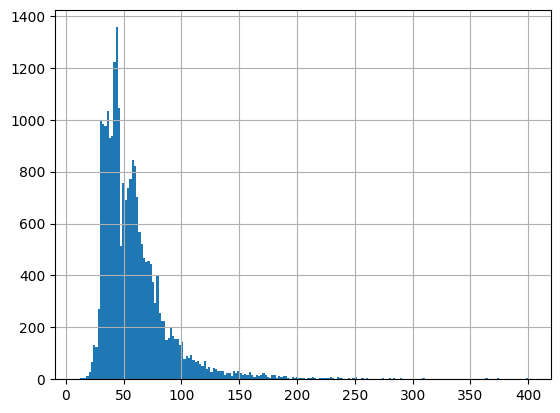

In [32]:
df['total_area'].hist(bins=200, range=(10, 400));

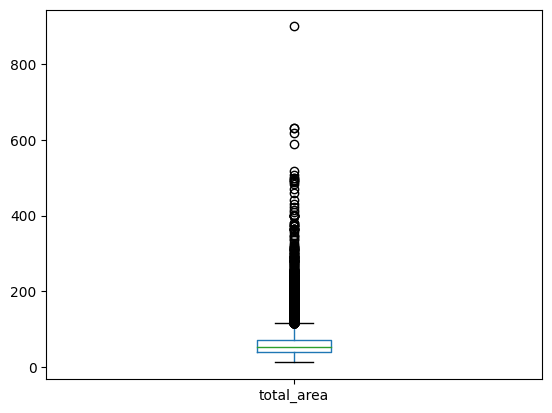

In [33]:
df['total_area'].plot.box();

**Общая площадь.**<br>
Разброс значений от 12 до 900 метров. Медианное значение 52, среднее 60. Видимо, оно завышается засчёт выбросов. Стандартное отклонение - 35 метров, что также указывает на большой разброс. На гистограмме можно выделить три пика около 35, 45 и 60м, которые дифференцируют типовые площади квартир в зависимости от числа комнат. Видно длинный хвост, начинающийся примерно от 130 метров, там находится редкое жильё с большой площадью. Боксплот показывает выдающиеся выбросы, начиная примерно с 500 метров.

In [34]:
df['living_area'].describe()

count    21771.000000
mean        34.489020
std         22.023718
min         10.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

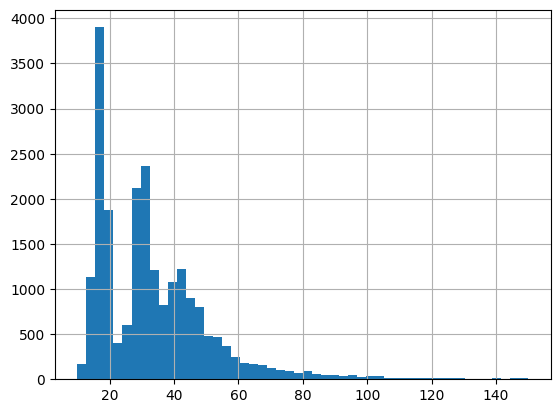

In [35]:
df['living_area'].hist(bins=50, range=(10, 150));

**Жилая площадь.**<br>
Разброс значений от 10 до 410 метров. Медиана - 30, среднее - 35. Стандартное отклонение - 22. Три пика в 18, 30 и 45м также выражены и дифференцируют площадь. Виден длинный хвост после 60 метров. Боксплот показывает наличие выдающихся выбросов после 270м. 

In [36]:
df['kitchen_area'].describe()

count    21605.000000
mean        10.461270
std          5.958325
min          0.000000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

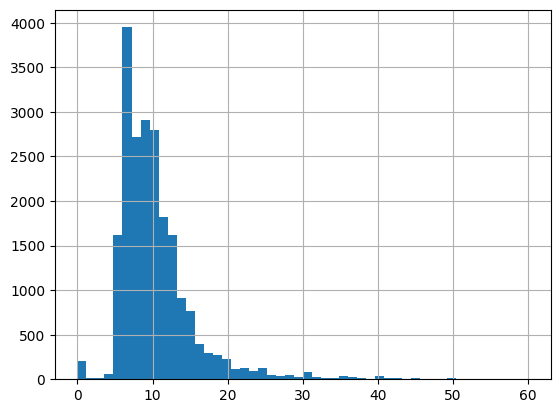

In [37]:
df['kitchen_area'].hist(bins=50, range=(0, 60));

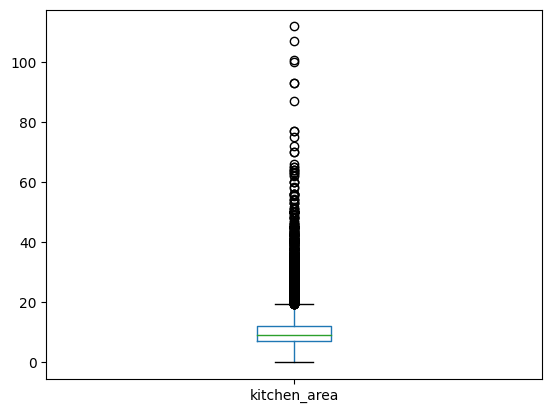

In [38]:
df['kitchen_area'].plot.box();

**Площадь кухни.**<br>
Разброс от 0 до 112м. Медиана - 9, среднее - 10. Отклонение - 6. На гистограмме видно малый пик на 0 (студии с невыделенной площадью кухни), крутой пик около 8м, длинный хвост начиная с 15м. Боксплот показывает выдающиеся выбросы после 70м. 

In [39]:
df['last_price'].describe()

count     23674.000000
mean       6541.402925
std       10885.848124
min         430.000000
25%        3400.000000
50%        4650.000000
75%        6800.000000
max      763000.000000
Name: last_price, dtype: float64

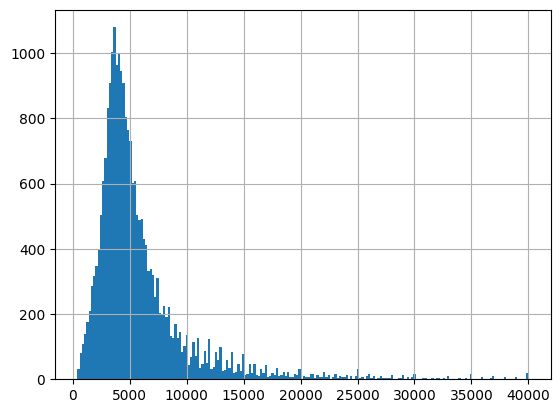

In [40]:
df['last_price'].hist(bins=200, range=(400,40000));

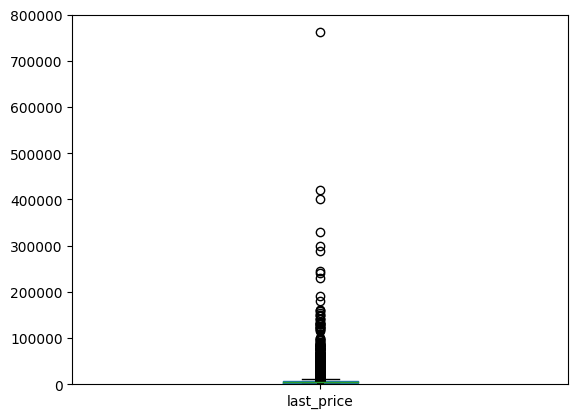

In [41]:
df['last_price'].plot.box();
plt.ylim(0, 800000);

**Цена объекта.**<br>
Разброс от 430тыс до 763млн. Медиана - 4.650млн, среднее - 6.541млн. Отклонение почти 11млн. Пик на гистограмме в районе 4,7млн. Длинный хвост от 9,8млн, откинув который можно получить почти идеально симметричный график. Боксплот показывает выдающиеся выбросы начиная с 200млн и совсем уж оторванное от остальных данных значение на 763млн.

In [42]:
df['rooms'].describe()

count    23674.000000
mean         2.071344
std          1.078401
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

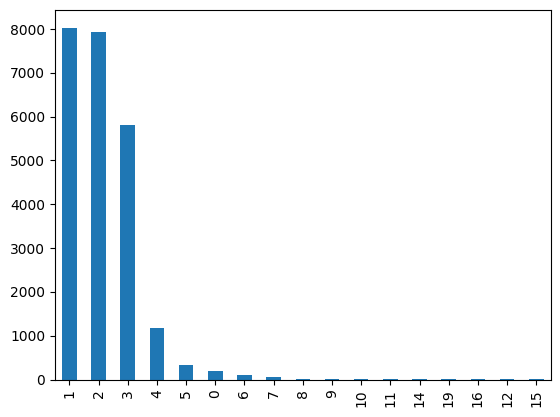

In [43]:
df['rooms'].value_counts().plot(kind='bar');

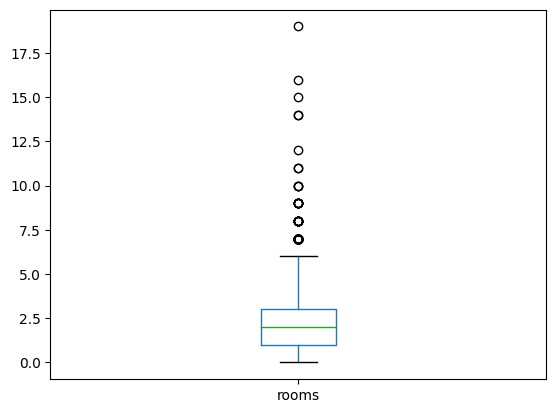

In [44]:
df['rooms'].plot.box();

**Количество комнат.**<br>
Разброс от 0 до 19. Медиана и среднее - 2. Отклонение - 1. На гистограмме два равных пика на 1 и 2. Хвост после 4. Боксплот показывает, что все выбросы довольно разрежены и начинаются после 6.

In [45]:
df['ceiling_height'].describe()

count    14487.000000
mean         2.727257
std          0.277769
min          2.300000
25%          2.520000
50%          2.650000
75%          2.800000
max          6.000000
Name: ceiling_height, dtype: float64

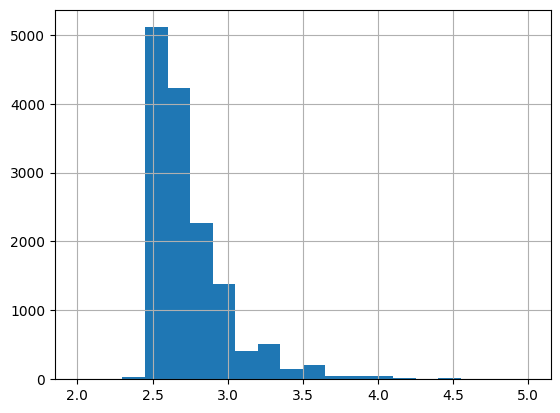

In [46]:
df['ceiling_height'].hist(bins=20, range=(2, 5));

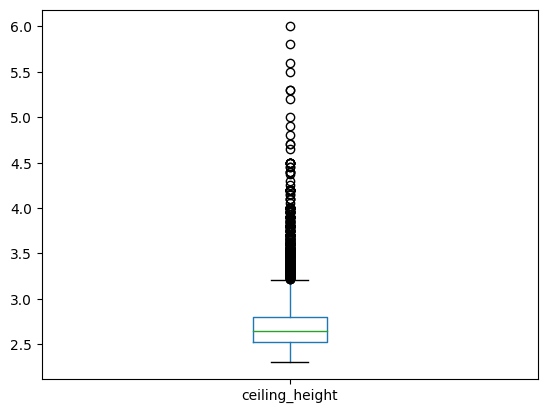

In [47]:
df['ceiling_height'].plot.box();

**Высота потолков.**<br>
Разброс от 2.3 до 6. Медиана и среднее - 2.7м. Отклонение - 0.3м. Крутой пик на стандартном значении в 2.7м. Хвост после 3. Выдающиеся выбросы после 4.5м.

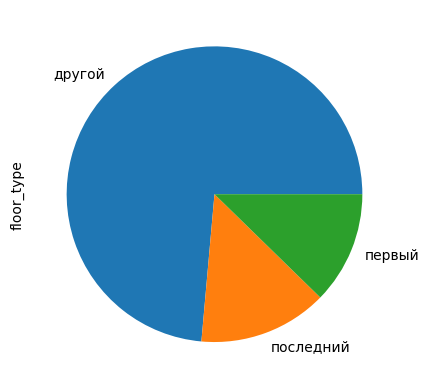

In [48]:
df['floor_type'].value_counts().plot(kind='pie');

**Тип этажа.**<br>
Количество первых и последних примерно равно и существенно меньше, чем "других".

In [49]:
df['floors_total'].describe()

count    23637.000000
mean        10.667301
std          6.588873
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

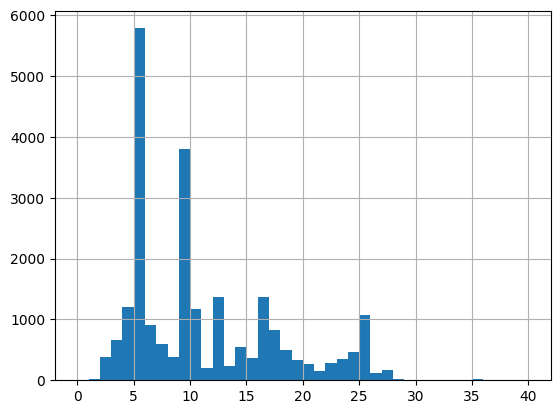

In [50]:
df['floors_total'].hist(bins=40, range=(0, 40));

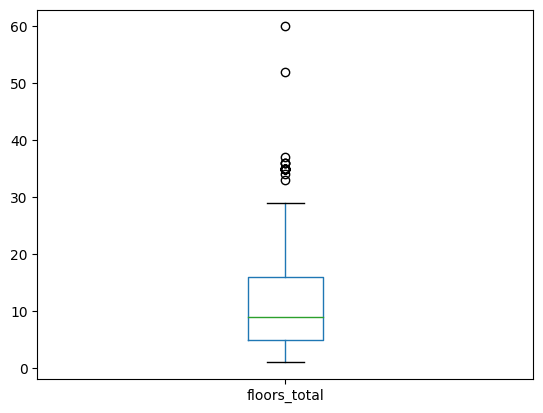

In [51]:
df['floors_total'].plot.box();

**Количество этажей в доме.**<br>
Разброс от 1 до 60. Медиана - 9, среднее - 11. Отклонение - 7. Пик на 5 и 9 этажах. Провалы в районе 7-8, 12 и 14. Выбросы начиная с 30.

In [52]:
df['cityCenters_nearest'].describe()

count    18156.000000
mean     14193.600573
std       8610.124346
min        181.000000
25%       9238.000000
50%      13100.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

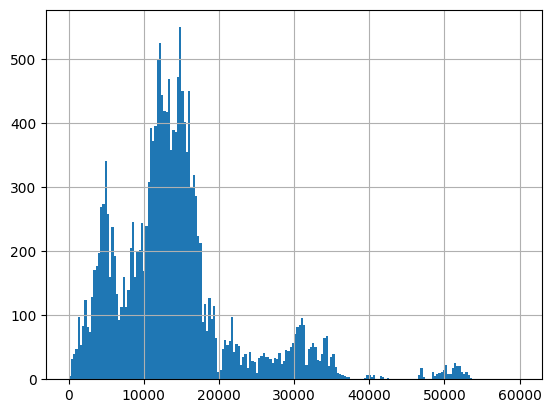

In [53]:
df['cityCenters_nearest'].hist(bins=200, range=(0, 60000));

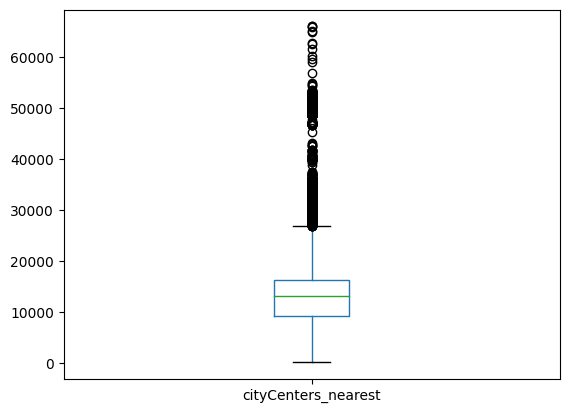

In [54]:
df['cityCenters_nearest'].plot.box();

**Расстояние до центра города в метрах.**<br>
Разброс от 181м до 66км. Медиана - 13км, среднее - 14. Отклонение - 8,6км. Пики в районе 5 и 15км. Длинный хвост после 18км, в котором переиодически просматриваются всплески (предположительно, наиболее крупные спальные районы на окраинах). Распределение выбросов после 27км довольно плотное.

In [55]:
df['parks_nearest'].describe()

count    8066.000000
mean      490.644061
std       342.034241
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

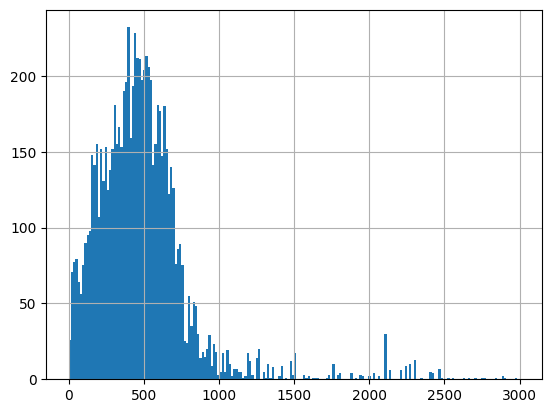

In [56]:
df['parks_nearest'].hist(bins=200, range=(0, 3000));

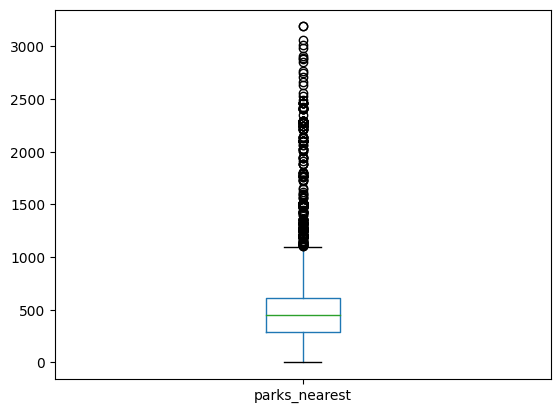

In [57]:
df['parks_nearest'].plot.box();

**Расстояние до ближайшего парка.**<br>
Разброс от 1м до 3.2км. Медиана - 455м, среднее - 491. Отклонение - 342м. Пик в районе 500м. Длинный хвост после 600м, в котором наблюдаются невысокие всплески. Распределение выбросов после 1км плотное.<br><br>
В целом графики показывают наличие выбросов, которые искажают основные показатели данных: сдвигают в большую сторону среднее значение, увеличивают стандартное отклонение, нарушают нормальность распределения, но поскольку целью исследования является изучение реальных характеристик рынка недвижимости, то за выбросами стоят редкие объекты и очистка может привести к искажённому пониманию характеристик рынка. Принимаю компромиссное решение очистить данные только от наиболее выдающихся выбросов.

In [58]:
df = df[df['total_area'] <= 600].reset_index(drop=True) #удаляю объекты общей площадью более 600м
df = df[df['living_area'] <= 350].reset_index(drop=True) #удаляю объекты c жилой площадью более 350м
df = df[df['kitchen_area'] <= 100].reset_index(drop=True) #удаляю объекты площадью кухни более 100м
df = df[df['last_price'] <= 500000].reset_index(drop=True) #удаляю объекты стоимостью более 500млн
df = df[df['rooms'] <= 15].reset_index(drop=True) #удаляю объекты с количеством комнат более 15
df = df[df['floors_total'] <= 40].reset_index(drop=True) #удаляю дома более 40 этажей

In [59]:
df['days_exposition'].describe()

count    18223.000000
mean       184.919113
std        221.564966
min          1.000000
25%         44.000000
50%        101.000000
75%        239.000000
max       1580.000000
Name: days_exposition, dtype: float64

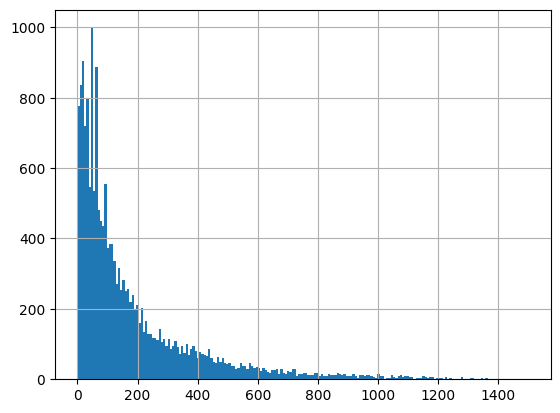

In [60]:
df['days_exposition'].hist(bins=200, range=(0, 1500));

**Время продажи.**<br>
Разброс от 1 до 1580 дней. Медиана - 101 день, среднее - 185. Отклонение - 222 дня. На гистограмме виден длинный хвост, начинающийся в районе 200 дней. Быстрые продажи сосредоточены слева от медианы, в диапазоне от 1 до 100 дней. Необычно долгие продажи находятся справа, в длинной части хвоста графика. Такими продажами в данном случае можно считать диапазон 400 - 1580 дней. Боксплот показывает, что выбросы начинаются в районе 500 дней. По распределению значений видно, что большая часть продаж совершается быстро, до 100 дней, а средний показатель завышен засчёт большого разброса значений в правой части графика.<br><br>

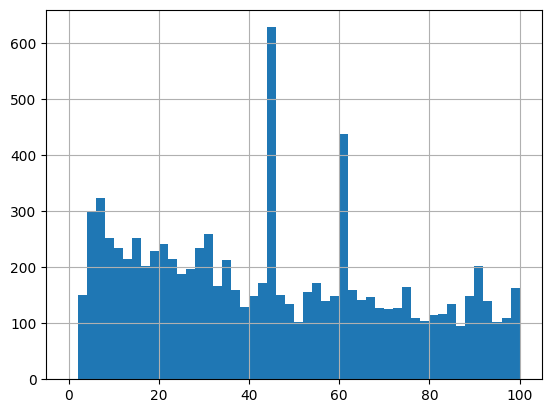

In [61]:
df['days_exposition'].hist(bins=50, range=(0, 100));

В диапазоне 0-100 видно три пика на 45, 60 и 90 дней - срок для автоматического снятия объявления.<br><br>
Далее определю факторы, которые больше всего влияют на общую (полную) стоимость объекта. Напишу пару функций, которые будут строить сводные таблицы. В качестве агрегирующей функции буду использовать медиану, помня про то, что среднее несколько завышено.

In [62]:
def table(values):
    return df.pivot_table(index='last_price', values=values, aggfunc='median')

def table_invert(index):
    return df.pivot_table(index=index, values='last_price', aggfunc='median')

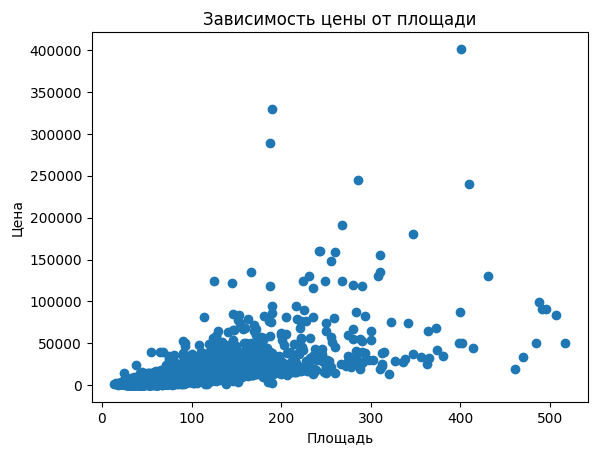

In [63]:
plt.scatter(df['total_area'], df['last_price']);
plt.xlabel('Площадь')
plt.ylabel('Цена')
plt.title('Зависимость цены от площади');

In [64]:
df['total_area'].corr(df['last_price'])

0.6735721570821911

**Зависимость цены от площади.** <br>
На гистограммах видно как распределено количество объектов в зависимости от цены и площади. Пик в левой части указывает на то, что большинство объектов имеют относительно невысокую цену и малую площадь. Коэффициент корреляции 0.67 указывает на наличие довольно сильной положительной линейной зависимости. Диаграмма рассеяния показывает выраженную линейную связь до зоны 50млн - 200м, с редкими выдающимися значениями, после чего просиходит разрыв связи, прежде всего в верхних диапазонах цены, где начинает происходить большой разброс значений. При этом линейная связь всё ещё прослеживается в нижнем диапазоне цены.

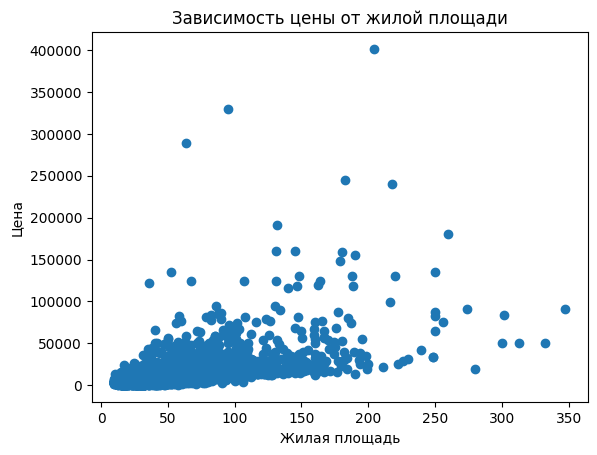

In [65]:
plt.scatter(df['living_area'], df['last_price'])
plt.xlabel('Жилая площадь')
plt.ylabel('Цена')
plt.title('Зависимость цены от жилой площади');

In [66]:
df['living_area'].corr(df['last_price'])

0.5985914597224296

**Зависимость цены от жилой площади.**<br>
Большая часть объектов имеет относительно малую жилую площадь и цену. Диаграмма рассеяния имеет чуть меньшую плотность распределения точек вдоль линии зависимости по сравнению с общей площадью. Зависимость выражена до зоны 50млн - 100м, после чего начинает разрушаться в верхнем ценовом диапазоне, в нижнем ценовом диапазоне всё ещё прослеживается до значения в 200м, после чего значения рассеиваются. Корреляция - 0,6. Чуть ниже, чем у общей площади.

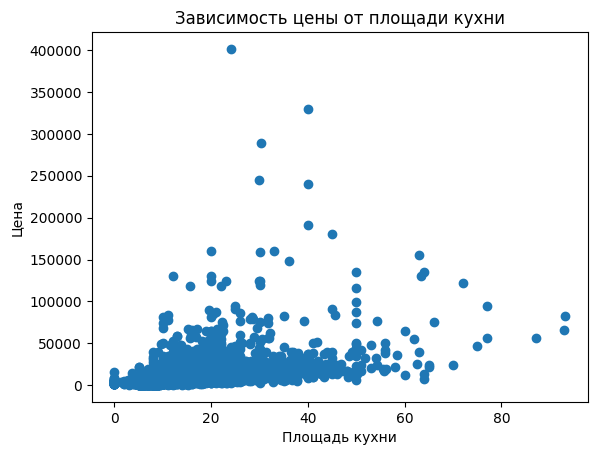

In [67]:
plt.scatter(df['kitchen_area'], df['last_price'])
plt.xlabel('Площадь кухни')
plt.ylabel('Цена')
plt.title('Зависимость цены от площади кухни');

In [68]:
df['kitchen_area'].corr(df['last_price'])

0.5063763121568954

**Зависимость цены от площади кухни.**<br>
Большая часть объектов имеет относительно малую площадь и невысокую цену. Плотность распределения вдоль линии зависимости ещё ниже, чем на диаграмме жилой площади. Значения начинают рассеиваться в зоне 50млн - 25м. При этом в нижнем ценовом диапазоне зависимость прослеживается вплоть до 60м. Корреляция продолжает снижаться и составляет 0,5.

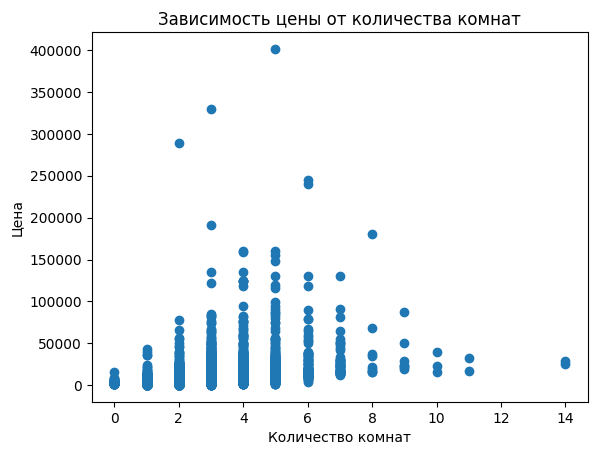

In [69]:
plt.scatter(df['rooms'], df['last_price'])
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.title('Зависимость цены от количества комнат');

In [70]:
df['rooms'].corr(df['last_price'])

0.39087225703842504

**Зависимость цены от количества комнат.**<br>
Точки сгруппированы в столбцы ввиду дискретности данных. В целом присутствует некая положительная связь в нижнем ценовом диапазоне, однако корреляция невысокая и составляет 0,39.

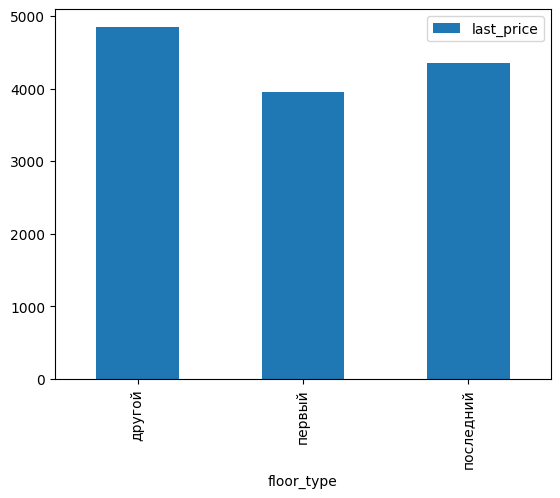

In [71]:
table_invert('floor_type').plot(kind='bar');

**Зависимость цены от типа этажа.**<br>
Цена на первый этаж в среднем будет ниже. Цена на последний этаж в среднем сопоставима с ценой на все другие этажи.<br><br>
Далее посмотрю на цену в зависимости от дня, месяца и года размещения объявления.

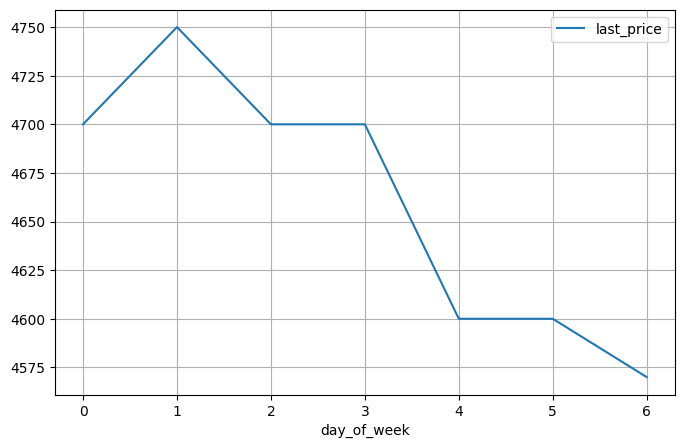

In [72]:
table_invert('day_of_week').plot(grid=True, figsize=(8,5));

В целом цена продажи чуть выше у объявлений, которые были выставлены в будние дни и снижается к выходным.

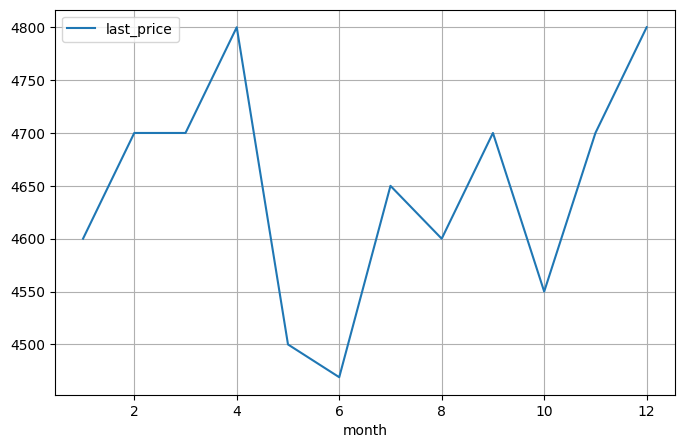

In [73]:
table_invert('month').plot(grid=True, figsize=(8,5));

Дороже всего недвижимость продавалась в апреле и декабре. Дешевле всего в июне.

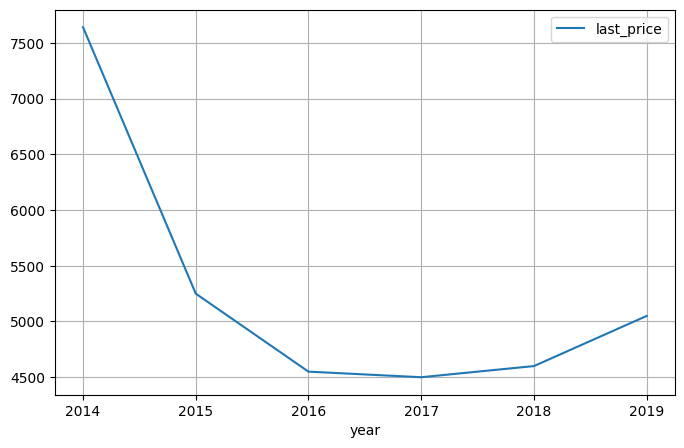

In [74]:
table_invert('year').plot(grid=True, figsize=(8,5));

Самая высокая средняя цена продажи пришлась на 2014 год, после чего произошёл откат и с 2017 года снова наметился рост.<br><br>
Далее посчитаю среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

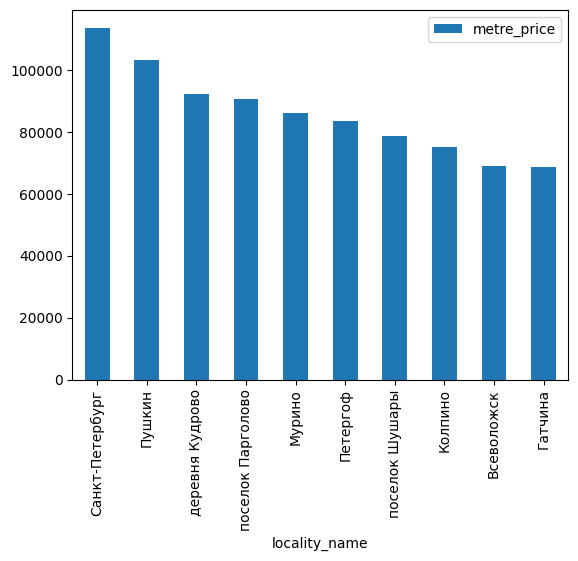

In [76]:
top10 = df['locality_name'].value_counts().head(10).index 
(df.query('locality_name in @top10')
    .pivot_table(index='locality_name', values='metre_price', aggfunc='mean')
    .sort_values(by='metre_price', ascending=False)
    .plot(kind='bar'));

Самая высокая средняя цена в Петербурге, самая низкая в Гатчине.<br><br>
Далее выделю квартиры в Санкт-Петербурге и вычислю их среднюю стоимость на разном удалении от центра.

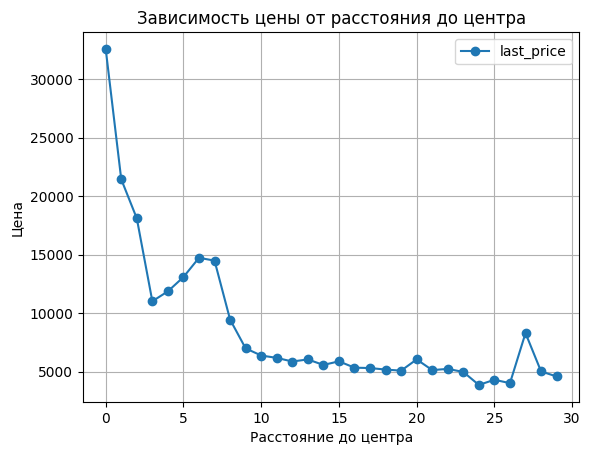

In [78]:
df_spb = df.query("locality_name == 'Санкт-Петербург' and center_km.notna()").copy() 
(df_spb.pivot_table(index='center_km', values='last_price', aggfunc='mean') 
    .astype(int)
    .reset_index()
    .plot(x='center_km', y='last_price', style='o-', grid=True))
plt.title('Зависимость цены от расстояния до центра')
plt.xlabel('Расстояние до центра')
plt.ylabel('Цена');

In [79]:
df_spb['last_price'].corr(df_spb['center_km'])

-0.3024921342132361

Коэффициент корреляции -0.3 показывает наличие неярко выраженной отрицательной связи. Цена снижается по мере удаления от центра, но не линейно. На графике видно, что цена резко падает при удалении от центра в диапазоне 0-3 км, затем наблюдается рост в диапазоне 3-7км (предположительно, это зона в центре города, где сосредоточена элитная недвижимость), после чего снова происходит резкий спад в диапазоне 7-10км, далее цена почти линейно уменьшается по мере удаления, вплоть до расстояния в 26км, где снова наблюдается некоторый рост. 

### Общий вывод

**В ходе предобработки были выявлены следующие проблемы в данных:**<br>
1. Множественные пропуски. Предположительно, одни возникли в результате некорректного внесения данных продавцами недвижимости, другие в результате сбора либо выгрузки данных с гео-сервиса. <br>
2. Аномальные значения.  Предположительно, возникли в результате некорректного внесения данных продавцами недвижимости.<br>
**Способы решения:**<br>
* Там, где это было логично сделать, пропуски были заполнены соответствующими медианными значениями. Прочие пропуски оставлены без изменений.<br>
* Аномальные значения были либо скорректированы вручную, в случае если была понятна природа их происхождения, либо удалены, если не поддавались корректировке. В целом была удалена незначительная часть строк, не влияющая на результат исследования.

**Целью ислледования были ответы на следующие вопросы:**<br>
1. Каковы основные характеристики объектов недвижимости?
2. Сколько времени обычно занимает продажа объекта?
3. Каковы основные факторы, наиболее влияющие на стоимость объекта?<br>

**1. Основными исследованными характеристиками являются:**<br> 
* **Общая площадь объекта:** средняя площадь составляет примерно 60 кв. м. и имеет относительно умеренные размеры. 25% объектов имеют площадь до 40 кв. м., 75% объектов имеют площадь до 70 кв. м. Стандартное отклонение в 36 кв.м. указывает на разброс значений вокруг среднего и разнообразие размеров жилой недвижимости в выборке.<br>
* **Жилая площадь объекта:** средняя площадь составляет примерно 35 кв. м. 25% объектов имеют жилую площадь менее 19 кв.м., а 75% - менее 42 кв.м. Стандартное отклонение составляет 22 кв. м. и говорит о значительном разбросе значений вокруг среднего, указывая на разнообразие размеров помещений в выборке.<br>
* **Площадь кухни:** средняя площадь 10.46 кв.м. 25% объектов имеют площадь кухни менее 7 кв.м., а 75% - менее 12 кв.м. Стандартное отклонение составляет 6 кв.м. и показывает, насколько разнообразны размеры кухонь в выборке.<br>
* **Цена объекта:** Средняя цена 6,541 млн.руб. Это среднее значение цены по всей выборке, которое может служить ориентиром при оценке стоимости недвижимости. 25% объектов имеют цену ниже 3,4 млн.руб., а 75% - ниже 6,8 млн.руб. Стандартное отклонение составляет 10,885 млн.руб. Это показывает, насколько сильно отличаются цены недвижимости в выборке от среднего значения, что указывает на большой разброс стоимости объектов недвижимости.<br>
* **Количество комнат:** среднее количество комнат - 2. 25% объектов имеют количество комнат - 1 или менее (квартиры-студии), а 75% - менее 3. Стандартное отклонение составляет 1.<br>
* **Высота потолков:** средняя высота потолков 2.73м., что является типовым значением. 25% объектов имеют высоту потолков менее 2.52 м., а 75% - менее 2.8 м. Стандартное отклонение составляет 0.28 метра. Это показывает, на незначительные отклонения от среднего и небольшой разброс значений в выборке.<br>
* **Тип этажа квартиры:** большая часть объектов находится не на первом и не на последнем этажах зданий.<br>
* **Количество этажей на объекте:** среднее количество этажей - 11. 25% объектов имеют количество этажей менее 5, а 75% - менее 16. Стандартное отклонение составляет 6. Это показывает большой разброс этажности зданий в выборке.
* **Расстояние до центра:** среднее расстояние до центра города: 14 км. 25% объектов имеют расстояние до центра города менее 9 км., а 75% - менее 16км. Стандартное отклонение составляет 9 км, что указывает на нахождение основной части объектов возле центра города.<br>
* **Расстояние до ближайшего парка:** среднее расстояние до парка 491 м. указывает на общую близость к зеленым зонам. 25% объектов имеют расстояние до парка менее 288 м., а 75% - менее 612 м. Стандартное отклонение составляет 342 м.<br>

**2. Скорость продажи объекта характеризуется следующим образом:**<br>
* Разброс от 1 до 1580 дней. Медиана - 101 день, среднее - 185. Отклонение - 222 дня. Быстрые продажи совершаются в срок менее 100 дней. Необычно долгими считаются продажи, занимающие более 400 дней. 25% продаж совершаются менее, чем за 44 дня, а 75% менее, чем за 239.<br>

**3. Основные факторы, влияющие на стоимость объекта в порядке убывания значимости:**<br>
* **Общая площадь объекта:** коэффициент корреляции 0.67, выраженная положительная линейная зависимость.
* **Жилая площадь объекта:** коэффициент корреляции 0.6, выраженная положительная линейная зависимость.
* **Площадь кухни:** коэффициент корреляции 0.51, умеренная положительная линейная зависимость.
* **Количество комнат:** коэффициент корреляции 0.39, слабо выраженная положительная линейная зависимость.
* **Тип этажа квартиры:** в среднем первые этажи дешевле прочих.
* **Дата размещения:** наибольшую стоимость имели сделки, размещённые в будние дни декабря, наименьшую в выходные дни июня.





**Также в ходе исследования были решены следующие задачи:**
* Определена средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Самая высокая цена - 113 861 руб. за кв.м. находится в Санкт-Петербурге, самая низкая - 58 319 руб. в Выборге.
* Вычислена средняя стоимость квартир в Санкт-Петербурге на разном удалении от центра и определена слабо выраженная отрицательная зависимость с коэффициентом корреляции -0.3.